# Building a High-Performance Model with LightGBM

This notebook presents a full pipeline for preparing and modeling high-frequency financial data using LightGBM.  
It is designed for volatility prediction based on order book information, and follows a robust ETL and training workflow.

### Objectives

- Load and preprocess raw order book data with the `LightGBMETL` class.
- Perform advanced feature engineering to extract meaningful volatility signals.
- Apply target encoding to incorporate stock-level behavior into the model.
- Train a LightGBM model using 5-fold cross-validation with custom RMSPE evaluation.
- Analyze and export feature importances to understand what drives the predictions.

### Requirements

To run this notebook on macOS, you may need to install OpenMP support for LightGBM:

```bash
brew install libomp

## Preparation

In [1]:
import pandas as pd
import numpy as np
from ETL.LightGBMETL import LightGBMETL
from ETL.utils import rmspe

### ETL Initialization

We create an instance of the `LightGBMETL` class, which handles loading and preprocessing of the data.  
The paths to the order book files (`orderbook_path`) and the training dataset (`train_path`) are provided.  
Then, we access the `train.csv` file and display the first few rows of the dataset.

In [2]:
ETL = LightGBMETL(
    orderbook_path = "optiver-realized-volatility-prediction/orderbook_train.parquet",
    train_path = "optiver-realized-volatility-prediction/train.csv",
)

train = ETL.train
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


### Feature Engineering from Order Book Data

We call the `.preprocessor()` method to extract features from the raw order book data.  
This function processes each stock’s data in parallel, applies feature engineering techniques, and returns a DataFrame (`train_df`) containing aggregated features per `row_id` (stock-time combination).

In [3]:
train_df = ETL.preprocessor()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   30.4s finished


### Merging Features with Target Variable

We create a `row_id` column by combining `stock_id` and `time_id`, which uniquely identifies each observation.  
Then, we keep only the `row_id` and `target` columns from the original training data and merge them with the engineered features (`train_df`) using a left join.


In [4]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
train_df = train_df.merge(train, on = ['row_id'], how = 'left')

## Target encoding by stock_id

### Stock ID Target Encoding with Cross-Validation

To encode the `stock_id` using its relationship with the target variable, we perform a form of target encoding.  
For each fold in a 10-fold cross-validation, we compute the mean target value per `stock_id` using only the training portion of that fold.  
These means are then mapped to the validation portion, helping avoid data leakage.  
The result is stored in a new feature called `stock_id_target_enc`, which captures the average behavior of each stock across different folds.

In [5]:
from sklearn.model_selection import KFold
#stock_id target encoding
train_df['stock_id'] = train_df['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = train_df.groupby('stock_id')['target'].mean() 

#training
tmp = np.repeat(np.nan, train_df.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(train_df):
    target_mean = train_df.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = train_df['stock_id'].iloc[idx_2].map(target_mean)
train_df['stock_id_target_enc'] = tmp

## LightGBM

In [6]:
import lightgbm as lgbm

Convert `stock_id` to integer, then split the data into features `X` (dropping `row_id` and `target`) and label `y` (the `target` column).

In [7]:
train_df['stock_id'] = train_df['stock_id'].astype(int)
X = train_df.drop(['row_id','target'],axis=1)
y = train_df['target']

### Custom Evaluation Metric and LightGBM Parameters

We define a custom evaluation function `feval_RMSPE`, which computes the Root Mean Square Percentage Error (RMSPE). This is a suitable metric for financial time series where percentage differences are more meaningful than absolute errors.

The LightGBM parameters are set up for regression using the RMSE loss. Some key configurations include:

- `learning_rate`: small step size for more stable convergence.
- `lambda_l1`, `lambda_l2`: L1 and L2 regularization to reduce overfitting.
- `feature_fraction` and `bagging_fraction`: control feature and sample subsampling, adding regularization.
- `early_stopping_rounds`: training stops if performance does not improve for 30 rounds.

This setup balances model complexity, regularization, and generalization.

In [8]:
def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

### Cross Validation

Import `KFold` and ETL utility functions, configure 5-fold CV (`random_state=19901028`, `shuffle=True`), and initialize:
- `oof`: empty DataFrame for out-of-fold predictions  
- `models`: list to store trained models  
- `scores`: float accumulator for validation scores  
- `gain_importance_list` & `split_importance_list`: lists to collect feature importances  

In [9]:
from sklearn.model_selection import KFold
from ETL.utils import calc_model_importance, plot_importance, calc_mean_importance

kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

  ### Model Training with Cross-Validation

Use `%%time` to measure the total runtime of a 5-fold LightGBM CV loop:

- For each fold:
  1. Split `X, y` into train/validation sets.
  2. Compute inverse-variance weights (1/`y`²) and build `lgbm.Dataset` for train and valid.
  3. Train with up to 5000 rounds, early stopping (30), and custom `feval_RMSPE`.
  4. Predict on validation, compute fold RMSPE, and accumulate into `scores`.
  5. Write each fold’s RMSPE and best iteration to `summary_lgbm/fold_{fold}.txt`.
  6. Calculate and store feature importances by gain and by split in their lists.

This process ensures robust evaluation and helps prevent overfitting by validating the model across multiple subsets of the data.

In [10]:
%%time

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      #verbose_eval=100,
                      #categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    
    #keep scores and models
    scores += RMSPE / 5
    models.append(model)

    with open("summary_lgbm/fold_{}.txt".format(fold+1), "w") as f:
        f.write("RMSPE: {}\n".format(RMSPE))
        f.write("Best Iteration: {}\n".format(model.best_iteration))
    
    feature_names = X_train.columns.values.tolist()
    gain_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='gain')
    gain_importance_list.append(gain_importance_df)

    split_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='split')
    split_importance_list.append(split_importance_df)

Fold : 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4957
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 20
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1235]	training's rmse: 0.000499485	training's RMSPE: 0.23116	valid_1's rmse: 0.000513643	valid_1's RMSPE: 0.23776
Fold : 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4957
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 20
[LightGBM] [Info] Start training from score 0.001795
Training until valida

### Feature Importance Aggregation and Export

After training the models across all folds, we aggregate the feature importance values (based on gain) using the `calc_mean_importance` function.  
We then visualize the average importance using `plot_importance`, which helps identify the most influential features in the model.  
Finally, the aggregated feature importance data is saved to a CSV file (`gain_importance_mean.csv`) for further analysis or reporting.

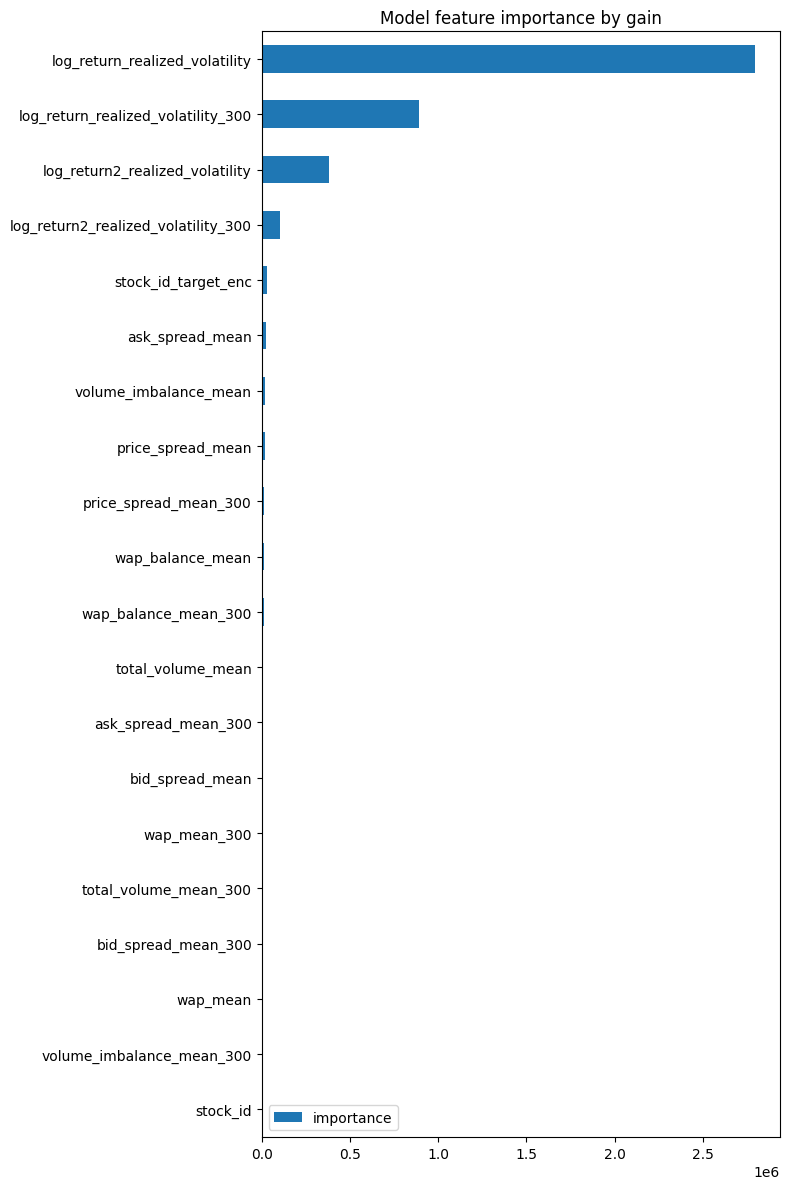

In [11]:
mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('output/gain_importance_mean.csv', index=False)

### Feature Importance by Split Count

In addition to gain-based importance, we also compute and visualize feature importance based on the number of splits.  
This metric reflects how often a feature is used to split data across all trees in the model.  
After aggregating the split importance across folds, we generate a plot to highlight frequently used features.  
The results are saved to a CSV file (`split_importance_mean.csv`) for documentation and further analysis.

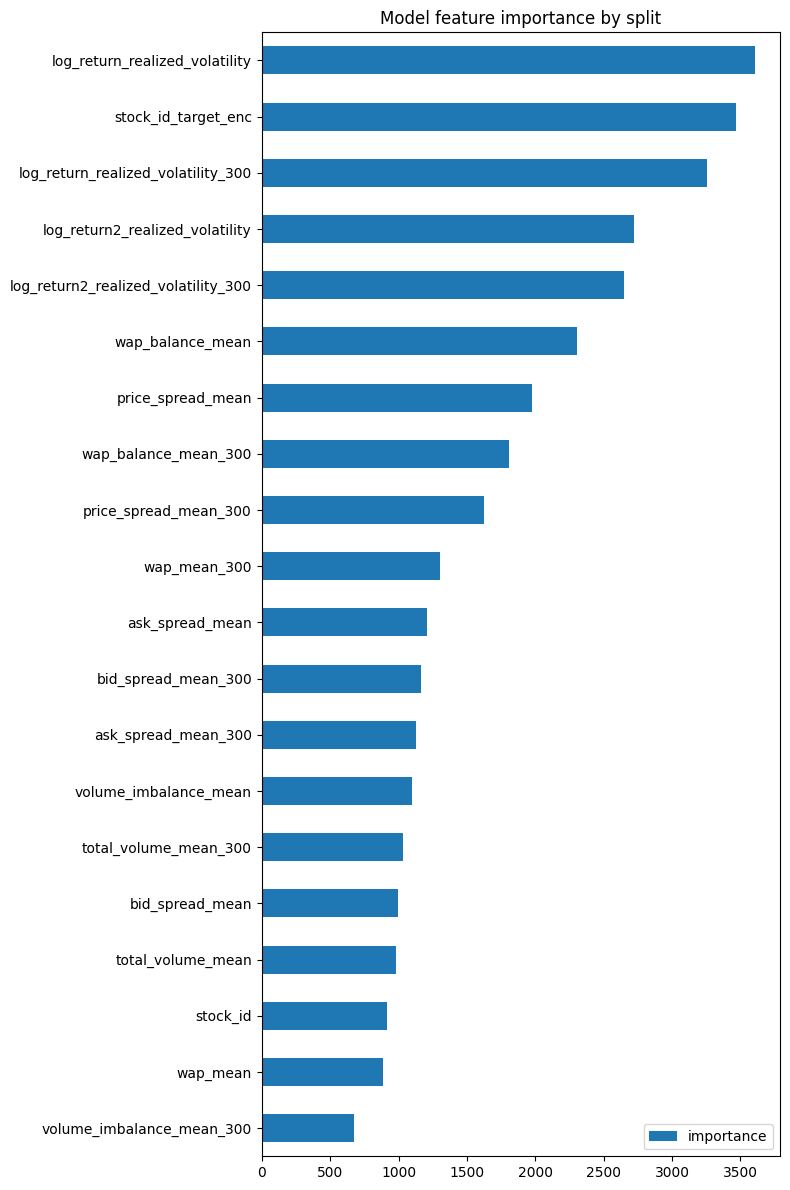

In [12]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('output/split_importance_mean.csv', index=False)